In [2]:
import numpy as np
from functools import partial
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs 
from numba import jit, vectorize, float64, int64
%matplotlib inline

## SGHMC

In [3]:
def hmc_1d(theta0,grad,M,C,epsilon,iter=1000):
    """
    This function outputs the 1 dimiension Hamilton Monte Carlo samples without M-H correction.
    
    Args: 
        theta0: the initial point of theta, the parameter of interest
        grad: the gradient of the potential
        M: the mass
        C: the C term, where C*M^{-1} is the friction
        epsilon: stepsize
        iter: iteration number, 1000 by default
    """
    r=np.random.normal(0,np.sqrt(M))
    theta=theta0
    theta_save=np.zeros(iter)
    r_save=np.zeros(iter)
    for t in range(iter):
        theta=theta+epsilon*r/M
        r=r-grad(theta)*epsilon-epsilon*C*r/M+np.random.normal(0,np.sqrt(2*epsilon*C))
        theta_save[t]=theta
        r_save[t]=r
    return theta_save,r_save

/opt/conda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


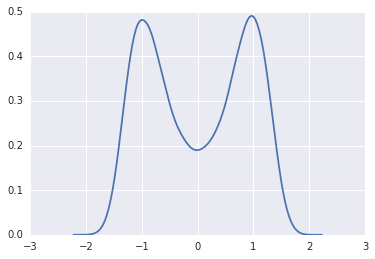

In [4]:
#####Rerun the example in Figure 1#####
theta0=0
M=1
C=1
grad=lambda theta: -4*theta+4*theta**3
epsilon=.1
iter=1000
theta_save,r_save=hmc_1d(theta0,grad,M,C,epsilon,iter=300000)
sns.kdeplot(theta_save)
pass

## The HMC function that incorporates data
#### Combine real data    
$U(\theta)=log(p(\theta|D)+log(p(\theta))$

Assume here the prior for $\theta$ $N(0,diag(2^2,4^2,5^2,0.1^2,0.1^2))$

$log(p(\theta|D_i)=y_ilogp+(1-y_i)log(1-p)=y_ilog(p/1-p)+log(1-p)=y_iX_i'\theta+log(\frac{1}{1+exp(X_i'\theta)})$   

$\frac{\partial log(p(\theta|D_i)}{\partial \theta}=y_iX_i-\frac{exp(X_i'\theta)}{1+exp(X_i'\theta)}X_i$
     
$log(p(\theta))=-1/2 \theta' V^{-1} \theta+C$   

$\frac{\partial log(p(\theta))}{\partial \theta}=- V^{-1} \theta$   

In [120]:
@jit(cache=True)
def gradlogistic(theta,X,y):  
    """
    theta:p.1-1d array
    X:n.p-2d array
    y n.1-1d array"""
    drll=np.diag(y-1/(1+np.exp(-X@theta)))@X
    drpri=-np.linalg.solve(np.diag([16,16,16,16,16]),theta)
    return -(drpri+drll.mean(axis=0))

In [121]:
gradlogistic(np.array([1,1,1,1,1]),np.eye(6,5),np.array([1,0,0,0,0,1]))

array([ 0.01767643,  0.1843431 ,  0.1843431 ,  0.1843431 ,  0.1843431 ])

In [122]:
@jit([float64[:,:](float64[:,:],float64[:],float64[:],float64[:,:],float64[:,:],float64, int64,int64)],cache=True)
def hmc_nbvec(X,y,theta0,M,C,epsilon,batchsize=50,iter=1000):
    """
    This function outputs the p dimiension Hamilton Monte Carlo samples without M-H correction.    
    Args: 
        X:n.p-2d array
        y n.1-1d array
        theta0: the initial point of theta, the parameter of interest
        grad: the gradient of the potential
        M: the mass
        C: the C term, where C*M^{-1} is the friction
        epsilon: stepsize
        p: the dimension of theta
        batchsize: the number of minibatch used
        iter: iteration number, 1000 by default
    """
    n=y.size
    T=X.shape[0]
    p=theta0.shape[0]
    r=np.random.multivariate_normal(np.zeros(p),M)
    theta=theta0
    theta_save=np.zeros([iter,p])
    r_save=np.zeros([iter,p])
    for t in range(iter):    
        mr=np.linalg.solve(M,r)
        theta=theta+epsilon*mr
        batch=np.random.choice(n,batchsize,replace=False)
        r=r-T*gradlogistic(theta,X[batch,:],y[batch])*epsilon-epsilon*np.dot(C,mr)+np.random.multivariate_normal(np.zeros(p),2*epsilon*C,1).ravel()
        theta_save[t,:]=theta
        r_save[t,:]=r
    return np.c_[theta_save,r_save]

In [75]:
###simulate data
def sim_log(m,n,theta):
    """This function outputs a simulated logistics regression dataset X and y. 
       X is a matrix of size m by n. Every entry of X is i.i.d N(0,1).
    Args:
        m: the number of rows in X
        n: the number of columns in X
        beta: a n by 1 vector, the true beta in the model
    """
    X=5*np.random.normal(loc=0,scale=1,size=[m,n])
    y=np.random.binomial(n=1,p=1/(1+np.exp(-(X @ theta))))
    return X,y

In [123]:
theta=np.array([-10,25,5,0,0])
X,y=sim_log(30000,5,theta)

In [124]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X, y)
clf.coef_

array([[ -5.24620016e+00,   1.31634856e+01,   2.61400225e+00,
         -9.68023609e-04,  -4.06010235e-03]])

In [125]:
theta0=np.zeros(5)
M=C=.001*np.identity(5)
epsilon=.001
size=300
out=hmc_nbvec(X,y,theta0,M,C,epsilon,size,iter=4000)

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


In [126]:
out[1000:,:5].mean(0)

array([-10.6982474 ,  27.88503373,   5.77315942,  -0.24045854,  -0.28012384])

## SGLD

In [91]:
@jit([float64[:,:](float64[:,:],float64[:],float64[:],float64[:,:],float64[:,:],float64, int64,int64)],cache=True)
def sgld_nbvec(X,y,theta0,M,C,epsilon,batchsize=50,iter=1000):
    """
    This function outputs the p dimiension Hamilton Monte Carlo samples without M-H correction.    
    Args: 
        X:n.p-2d array
        y n.1-1d array
        theta0: the initial point of theta, the parameter of interest
        grad: the gradient of the potential
        M: the mass
        C: the C term, where C*M^{-1} is the friction
        epsilon: stepsize
        p: the dimension of theta
        batchsize: the number of minibatch used
        iter: iteration number, 1000 by default
    """
    n=y.size
    T=X.shape[0]
    p=theta0.shape[0]
    theta=theta0
    theta_save=np.zeros([iter,p])
    for t in range(iter):    
        batch=np.random.choice(n,batchsize,replace=False)
        theta=theta-T*gradlogistic(theta,X[batch,:],y[batch])*epsilon+np.random.multivariate_normal(np.zeros(p),2*epsilon*np.identity(p),1).ravel()
        theta_save[t,:]=theta
    return theta_save

In [106]:
theta0=np.zeros(5)
M=C=np.identity(5)
epsilon=.001
size=300
out=sgld_nbvec(X,y,theta0,M,C,epsilon,size,iter=4000)

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


In [107]:
out.mean(0)

array([-11.59194921,  27.55566665,   5.03603019,   3.55927103,  -0.18496355])

In [94]:
X.shape[0]

30000